# Flight Price Prediction Project

 Anyone who has booked a flight ticket knows how unexpectedly the prices vary. The cheapest available ticket on a given flight gets more and less expensive over time. In this project we have first scraped data from "yatra.com" using Selenium and then build a regression model predicting prices.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import r2_score,mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample
import pickle

import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [2]:
df=pd.read_csv(r"FlightData.csv", parse_dates=["Date"])
df.head()

,Unnamed: 0,Name,Date,Departure,Arrival,Source,Destination,Stops,Duration,Price
0,0,IndiGo,24-Jan,22:40,01:30 + 1 day,New Delhi,Chennai,Non Stop,2h 50m,"2,341"
1,1,IndiGo,24-Jan,3:00,5:55,New Delhi,Chennai,Non Stop,2h 55m,"2,341"
2,2,IndiGo,24-Jan,8:35,11:30,New Delhi,Chennai,Non Stop,2h 55m,"2,341"
3,3,IndiGo,24-Jan,20:15,23:10,New Delhi,Chennai,Non Stop,2h 55m,"2,341"
4,4,IndiGo,24-Jan,9:50,12:50,New Delhi,Chennai,Non Stop,3h 00m,"2,341"


In [3]:
df.columns

Index(['Unnamed: 0', 'Name', 'Date', 'Departure', 'Arrival', 'Source',
       'Destination', 'Stops', 'Duration', 'Price'],
      dtype='object')

#### Features:

Name: name of Airline

Date: date of journey

Departure: time of departure

Arrival: time of arrival

Source: the source from which service begins

Destination: the destination where service ends

Stops: total number of stops between source and destination

Duration: total duration of flight

Price: Price of flight ticket

In [4]:
df.isnull().sum()

Unnamed: 0     0
Name           0
Date           0
Departure      0
Arrival        0
Source         0
Destination    0
Stops          0
Duration       0
Price          0
dtype: int64

The dataset has no null values.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1875 entries, 0 to 1874
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   1875 non-null   int64 
 1   Name         1875 non-null   object
 2   Date         1875 non-null   object
 3   Departure    1875 non-null   object
 4   Arrival      1875 non-null   object
 5   Source       1875 non-null   object
 6   Destination  1875 non-null   object
 7   Stops        1875 non-null   object
 8   Duration     1875 non-null   object
 9   Price        1875 non-null   object
dtypes: int64(1), object(9)
memory usage: 146.6+ KB


In [6]:
df.shape

(1875, 10)

Number of columns= 10

Number of rows= 1875

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.shape

(1875, 10)

There is no duplicate data

In [9]:
# Changing data type of price
p=[]
price=df["Price"]
for i in range(len(price)):
    st=price[i]
    p.append(st.replace(",",""))
df["Price"]=p

df_type_dict={'Price':int}
df=df.astype(df_type_dict)
df.dtypes

Unnamed: 0      int64
Name           object
Date           object
Departure      object
Arrival        object
Source         object
Destination    object
Stops          object
Duration       object
Price           int32
dtype: object

## Exploratory Data Analysis

### Univariate Analysis

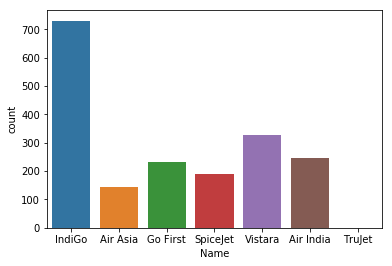

In [10]:
sns.countplot(df["Name"])

In [11]:
df['Source'].value_counts()

New Delhi    434
Mumbai       333
Bangalore    332
Kolkata      255
Pune         180
Hyderabad    130
Chennai      101
Patna         60
Jammu         50
Name: Source, dtype: int64

In [12]:
df['Destination'].value_counts()

New Delhi      665
Mumbai         284
Goa            205
Bangalore      120
Chennai        110
Kolkata         90
Lucknow         80
Jammu           51
Hyderabad       30
Guwahati        20
Pune            20
Srinagar        20
Indore          20
Coimbatore      20
Kochi           20
Port Blair      20
Dehradun        20
Tirupati        10
Ahmedabad       10
Rajahmundry     10
Trivandrum      10
Imphal          10
Vijayawada      10
Varanasi        10
Chandigarh      10
Name: Destination, dtype: int64

In [13]:
pd.crosstab(df['Source'],df['Destination'])

Destination,Ahmedabad,Bangalore,Chandigarh,Chennai,Coimbatore,Dehradun,Goa,Guwahati,Hyderabad,Imphal,...,Mumbai,New Delhi,Port Blair,Pune,Rajahmundry,Srinagar,Tirupati,Trivandrum,Varanasi,Vijayawada
Source,,,,,,,,,,,,,,,,,,,,,
Bangalore,0,0,0,0,0,0,0,0,0,0,...,0,332,0,0,0,0,0,0,0,0
Chennai,0,0,0,0,0,0,0,0,0,0,...,0,60,0,0,0,0,0,0,0,0
Hyderabad,10,20,0,20,0,10,10,0,0,0,...,0,10,0,0,10,0,10,0,0,0
Jammu,0,0,0,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Kolkata,0,10,0,20,0,0,20,20,20,0,...,95,20,10,20,0,20,0,0,0,0
Mumbai,0,20,10,0,20,10,20,0,0,0,...,0,183,0,0,0,0,0,0,10,0
New Delhi,0,10,0,20,0,0,155,0,10,10,...,189,0,10,0,0,0,0,10,0,10
Patna,0,60,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pune,0,0,0,0,0,0,0,0,0,0,...,0,60,0,0,0,0,0,0,0,0


In [14]:
#row of the entire dataset where the price is maximum
df.loc[df['Price'].idxmax()]

Unnamed: 0          1604
Name           Air India
Date              30-Nov
Departure           5:55
Arrival            19:05
Source           Chennai
Destination        Jammu
Stops          3 Stop(s)
Duration         13h 10m
Price              34539
Name: 1604, dtype: object

In [15]:
#row of the entire dataset where the price is miniimum
df.loc[df['Price'].idxmin()]

Unnamed: 0           300
Name            Go First
Date              24-Nov
Departure          16:00
Arrival            17:10
Source         Hyderabad
Destination      Chennai
Stops           Non Stop
Duration          1h 10m
Price               1789
Name: 300, dtype: object

In [16]:
#stats of airlines with total stops
pd.crosstab(df['Name'],df['Stops'])

Stops,1 Stop,2 Stop(s),3 Stop(s),Non Stop
Name,,,,
Air Asia,86,0,0,58
Air India,147,58,1,42
Go First,129,1,0,101
IndiGo,452,15,0,264
SpiceJet,104,2,0,85
TruJet,0,0,0,1
Vistara,192,32,4,101


### Bivariate Analysis

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

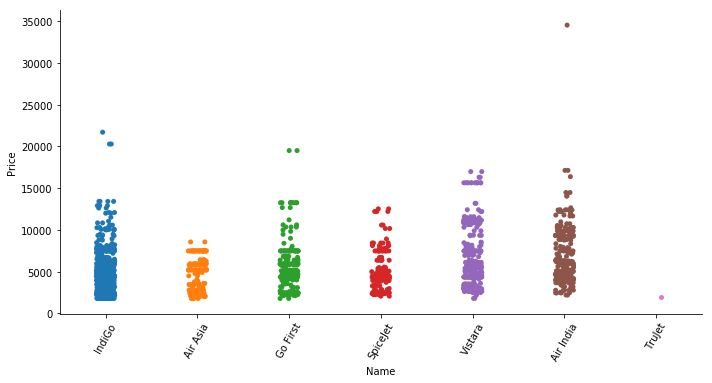

In [17]:
sns.catplot(x="Name", y="Price", data=df, aspect=2)
plt.xticks(rotation=60)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

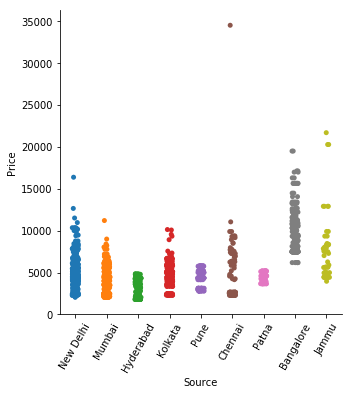

In [18]:
sns.catplot(x="Source", y="Price", data=df, aspect=1)
plt.xticks(rotation=60)

Flights from bangalore and jammu have higher price 

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

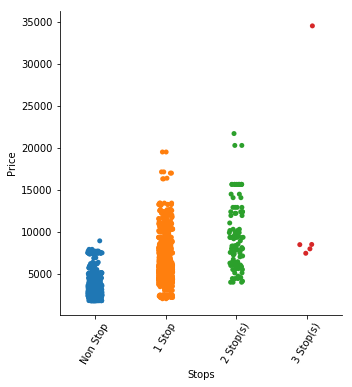

In [19]:
sns.catplot(x="Stops", y="Price", data=df)
plt.xticks(rotation=60)

Flights taking longer route i.e. with more number of stops have higher price.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

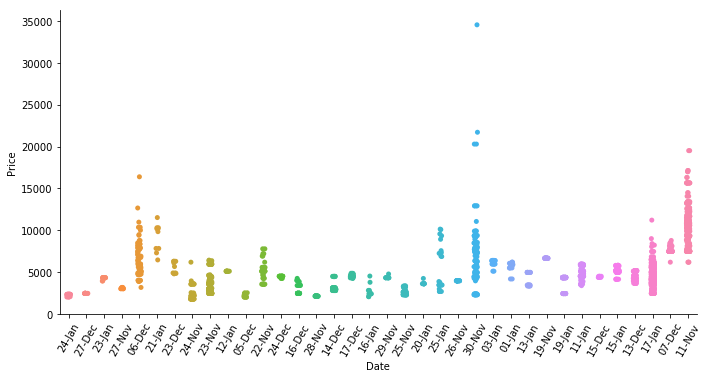

In [20]:
sns.catplot(x="Date", y="Price", data=df, aspect=2)
plt.xticks(rotation=60)

We observe that flights of november month which is the next month is high as compared to next coming monts.

In [21]:
df['Price'].groupby(df['Source']).mean()

Source
Bangalore    9757.198795
Chennai      4591.564356
Hyderabad    3018.661538
Jammu        7805.140000
Kolkata      4784.031373
Mumbai       4065.588589
New Delhi    4742.230415
Patna        4529.300000
Pune         4154.000000
Name: Price, dtype: float64

Flights from bangalore have highest price

In [22]:
df['Price'].groupby(df['Name']).mean()

Name
Air Asia     4884.277778
Air India    6743.193548
Go First     5355.112554
IndiGo       4743.179207
SpiceJet     4936.020942
TruJet       2021.000000
Vistara      6420.826748
Name: Price, dtype: float64

Air India and Vistara flights are expensive.

### Data Cleaning

In [23]:
df.drop(columns=["Unnamed: 0"], inplace=True)

Below few steps include cleaning of data to make it easy to analyze. We are first going to form a new dataframe 'time' and then extract information from it to form a new column.

In [24]:
time= df[["Departure","Arrival","Duration","Date"]]
time=pd.DataFrame(time)
time.head()

,Departure,Arrival,Duration,Date
0,22:40,01:30 + 1 day,2h 50m,24-Jan
1,3:00,5:55,2h 55m,24-Jan
2,8:35,11:30,2h 55m,24-Jan
3,20:15,23:10,2h 55m,24-Jan
4,9:50,12:50,3h 00m,24-Jan


In [25]:
list=[]
hrs=[]
min=[]
list=time["Departure"]
for i in range(len(list)):
    str=[]
    str=list[i].split(':')
    hrs.append(str[0])  ## Seperating hours and minutes
    min.append(str[1])
time["Dep_time_hours"]=hrs
time["Dep_time_min"]=min

In [26]:
list=[]
hrs=[]
min=[]
list=time["Duration"]
for i in range(len(list)):
    str=[]
    str=list[i].split(' ')
    if(len(str)>1):
        hrs.append(str[0][:-1])   ## Seperating hours and minutes
        min.append(str[1][:-1])
    else:
        hrs.append(list[i][:-1])
        min.append('0')
time["Duration_hours"]=hrs
time["Duration_min"]=min

In [27]:
list=[]
hrs=[]
min=[]
list=time["Arrival"]
for i in range(len(list)):
    str=[]
    str=list[i].split(':')
    hrs.append(str[0])  ## Seperating hours and minutes
    min.append(str[1][:3])
time["Arrival_time_hours"]=hrs
time["Arrival_time_min"]=min

In [28]:
list=[]
d=[]
m=[]
list=time["Date"]
for i in range(len(list)):
    d.append(list[i][:2])  ## Seperating date and month
    m.append(list[i][3:])
time["day"]=d
time["month"]=m

In [29]:
month=[]
for i in time["month"]:
    if i=="Jan":
        month.append(1)
    elif i=="Feb":
        month.append(2)
    elif i=="Mar":
        month.append(3)
    elif i=="Apr":
        month.append(4)
    elif i=="May":
        month.append(5)
    elif i=="Jun":
        month.append(6)
    elif i=="Jul":
        month.append(7)
    elif i=="Aug":
        month.append(8)
    elif i=="Sep":
        month.append(9)
    elif i=="Oct":
        month.append(10)
    elif i=="Nov":
        month.append(11)
    elif i=="Dec":
        month.append(12)
    else:
        month.append(np.nan)
time["month"]=month

In [30]:
time.head()

,Departure,Arrival,Duration,Date,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month
0,22:40,01:30 + 1 day,2h 50m,24-Jan,22,40,2,50,01,30,24,1
1,3:00,5:55,2h 55m,24-Jan,3,00,2,55,5,55,24,1
2,8:35,11:30,2h 55m,24-Jan,8,35,2,55,11,30,24,1
3,20:15,23:10,2h 55m,24-Jan,20,15,2,55,23,10,24,1
4,9:50,12:50,3h 00m,24-Jan,9,50,3,00,12,50,24,1


In [31]:
time.drop(columns=["Departure","Arrival","Duration","Date"],inplace=True)

In [32]:
data=pd.concat([df,time],axis=1) # joining both dataframes
data.head()

,Name,Date,Departure,Arrival,Source,Destination,Stops,Duration,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month
0,IndiGo,24-Jan,22:40,01:30 + 1 day,New Delhi,Chennai,Non Stop,2h 50m,2341,22,40,2,50,01,30,24,1
1,IndiGo,24-Jan,3:00,5:55,New Delhi,Chennai,Non Stop,2h 55m,2341,3,00,2,55,5,55,24,1
2,IndiGo,24-Jan,8:35,11:30,New Delhi,Chennai,Non Stop,2h 55m,2341,8,35,2,55,11,30,24,1
3,IndiGo,24-Jan,20:15,23:10,New Delhi,Chennai,Non Stop,2h 55m,2341,20,15,2,55,23,10,24,1
4,IndiGo,24-Jan,9:50,12:50,New Delhi,Chennai,Non Stop,3h 00m,2341,9,50,3,00,12,50,24,1


In [33]:
df["Stops"].value_counts()

1 Stop       1110
Non Stop      652
2 Stop(s)     108
3 Stop(s)       5
Name: Stops, dtype: int64

In [34]:
# Encoding Total_Stops Column
data["Stops"]=data["Stops"].replace({'Non Stop':0,'1 Stop':1,'2 Stop(s)':2,'3 Stop(s)':3,'4 Stop(s)':4})
data.head()

,Name,Date,Departure,Arrival,Source,Destination,Stops,Duration,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month
0,IndiGo,24-Jan,22:40,01:30 + 1 day,New Delhi,Chennai,0,2h 50m,2341,22,40,2,50,01,30,24,1
1,IndiGo,24-Jan,3:00,5:55,New Delhi,Chennai,0,2h 55m,2341,3,00,2,55,5,55,24,1
2,IndiGo,24-Jan,8:35,11:30,New Delhi,Chennai,0,2h 55m,2341,8,35,2,55,11,30,24,1
3,IndiGo,24-Jan,20:15,23:10,New Delhi,Chennai,0,2h 55m,2341,20,15,2,55,23,10,24,1
4,IndiGo,24-Jan,9:50,12:50,New Delhi,Chennai,0,3h 00m,2341,9,50,3,00,12,50,24,1


In [35]:
data.drop(columns=["Date","Departure","Arrival","Duration"],inplace=True)

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1875 entries, 0 to 1874
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Name                1875 non-null   object
 1   Source              1875 non-null   object
 2   Destination         1875 non-null   object
 3   Stops               1875 non-null   int64 
 4   Price               1875 non-null   int32 
 5   Dep_time_hours      1875 non-null   object
 6   Dep_time_min        1875 non-null   object
 7   Duration_hours      1875 non-null   object
 8   Duration_min        1875 non-null   object
 9   Arrival_time_hours  1875 non-null   object
 10  Arrival_time_min    1875 non-null   object
 11  day                 1875 non-null   object
 12  month               1875 non-null   int64 
dtypes: int32(1), int64(2), object(10)
memory usage: 262.3+ KB


In [37]:
df_type_dict={'Dep_time_hours':int,'Dep_time_min':int,'Duration_hours':int,'Duration_min':int,
              'Arrival_time_hours':int,'Arrival_time_min':int,'day':int}
data=data.astype(df_type_dict)
data.dtypes

Name                  object
Source                object
Destination           object
Stops                  int64
Price                  int32
Dep_time_hours         int32
Dep_time_min           int32
Duration_hours         int32
Duration_min           int32
Arrival_time_hours     int32
Arrival_time_min       int32
day                    int32
month                  int64
dtype: object

In [38]:
time.head()

,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month
0,22,40,2,50,01,30,24,1
1,3,00,2,55,5,55,24,1
2,8,35,2,55,11,30,24,1
3,20,15,2,55,23,10,24,1
4,9,50,3,00,12,50,24,1


Since we know price of flight varies on number of days before it is booked we will calculate number of days from todays date.

In [39]:
data["month"].value_counts()

11    744
1     703
12    428
Name: month, dtype: int64

In [40]:
for i in data["month"]:
    if i==1:
        data["Number_of_days"]=(data["day"]+31+4+30)
    elif i==12:
        data["Number_of_days"]=(data["day"]+30+4)
    elif i==11:
        data["Number_of_days"]=(data["day"]+4)
    else:
        print("Add another condition")

In [41]:
#introducing a new column total duration
data["Total_duration"]=data["Duration_hours"]*60+data["Duration_min"]

In [42]:
data.head()

,Name,Source,Destination,Stops,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month,Number_of_days,Total_duration
0,IndiGo,New Delhi,Chennai,0,2341,22,40,2,50,1,30,24,1,89,170
1,IndiGo,New Delhi,Chennai,0,2341,3,0,2,55,5,55,24,1,89,175
2,IndiGo,New Delhi,Chennai,0,2341,8,35,2,55,11,30,24,1,89,175
3,IndiGo,New Delhi,Chennai,0,2341,20,15,2,55,23,10,24,1,89,175
4,IndiGo,New Delhi,Chennai,0,2341,9,50,3,0,12,50,24,1,89,180


In [43]:
data.shape

(1875, 15)

Data now consists of 1875 rows and 15 columns. We will now move forward to encode name columns present in data using Label Encoder.

In [44]:
lab_enc=LabelEncoder()
cols=["Name", "Source", "Destination"]
for i in cols:
    df1= lab_enc.fit_transform(data[i])
    data[i]=df1
data.head()

,Name,Source,Destination,Stops,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month,Number_of_days,Total_duration
0,3,6,3,0,2341,22,40,2,50,1,30,24,1,89,170
1,3,6,3,0,2341,3,0,2,55,5,55,24,1,89,175
2,3,6,3,0,2341,8,35,2,55,11,30,24,1,89,175
3,3,6,3,0,2341,20,15,2,55,23,10,24,1,89,175
4,3,6,3,0,2341,9,50,3,0,12,50,24,1,89,180


### Check for correlation

In [45]:
data.corr()

,Name,Source,Destination,Stops,Price,Dep_time_hours,Dep_time_min,Duration_hours,Duration_min,Arrival_time_hours,Arrival_time_min,day,month,Number_of_days,Total_duration
Name,1.000000,0.012011,0.086426,-0.012724,0.049375,0.002984,0.029903,0.063044,-0.007177,0.084133,0.052620,0.104167,0.015470,0.104167,0.062604
Source,0.012011,1.000000,-0.216163,-0.174552,-0.498705,0.020732,-0.034239,-0.076989,-0.078893,-0.069235,0.017983,0.104426,-0.354967,0.104426,-0.080237
Destination,0.086426,-0.216163,1.000000,0.045637,0.239752,-0.061705,0.036615,0.113240,-0.045060,-0.025018,-0.068256,-0.271009,0.034060,-0.271009,0.111062
Stops,-0.012724,-0.174552,0.045637,1.000000,0.522638,-0.068450,-0.000023,0.683791,0.039989,0.103011,-0.011096,-0.060707,-0.079346,-0.060707,0.684110
Price,0.049375,-0.498705,0.239752,0.522638,1.000000,-0.101846,0.045445,0.390491,0.077265,0.073045,-0.016928,-0.360991,0.178698,-0.360991,0.393024
Dep_time_hours,0.002984,0.020732,-0.061705,-0.068450,-0.101846,1.000000,0.011187,0.003661,-0.021645,0.072706,-0.023270,-0.003273,0.053439,-0.003273,0.002719
Dep_time_min,0.029903,-0.034239,0.036615,-0.000023,0.045445,0.011187,1.000000,0.003760,-0.041540,-0.061554,-0.022913,0.011813,0.056419,0.011813,0.001958
Duration_hours,0.063044,-0.076989,0.113240,0.683791,0.390491,0.003661,0.003760,1.000000,0.026085,0.006110,0.023424,-0.096733,-0.100906,-0.096733,0.999068
Duration_min,-0.007177,-0.078893,-0.045060,0.039989,0.077265,-0.021645,-0.041540,0.026085,1.000000,0.025817,0.010820,-0.057034,0.015098,-0.057034,0.069210
Arrival_time_hours,0.084133,-0.069235,-0.025018,0.103011,0.073045,0.072706,-0.061554,0.006110,0.025817,1.000000,0.003181,-0.004045,0.069432,-0.004045,0.007212


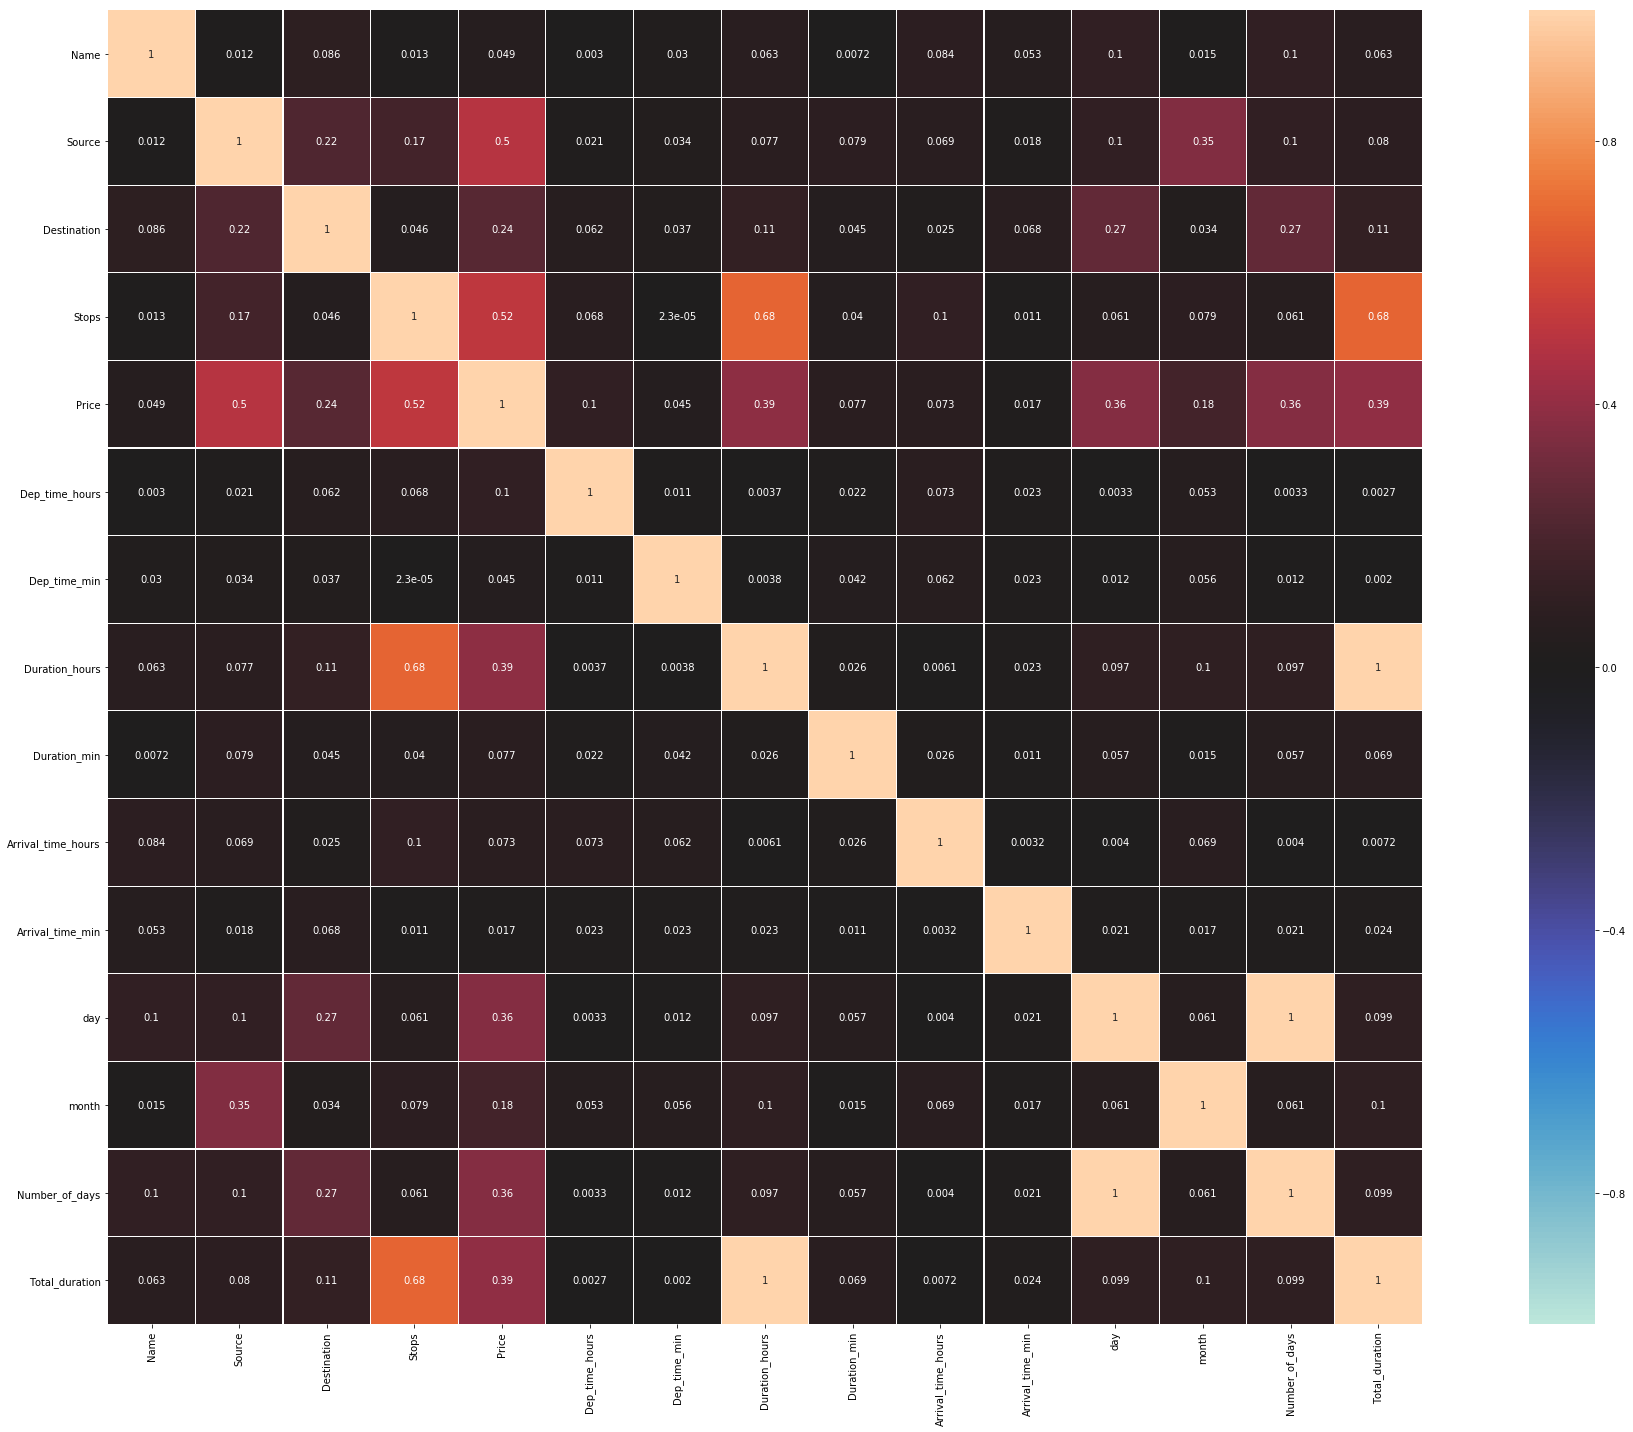

In [46]:
## HeatMap
df_corr= data.corr().abs()
plt.figure(figsize=(30,20))
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True, square=True, center=0, fmt='.2g', linewidth=.1)
plt.tight_layout()

In [47]:
# Correlation with target variable
corr_mat=data.corr()
corr_mat["Price"].sort_values(ascending=False)

Price                 1.000000
Stops                 0.522638
Total_duration        0.393024
Duration_hours        0.390491
Destination           0.239752
month                 0.178698
Duration_min          0.077265
Arrival_time_hours    0.073045
Name                  0.049375
Dep_time_min          0.045445
Arrival_time_min     -0.016928
Dep_time_hours       -0.101846
Number_of_days       -0.360991
day                  -0.360991
Source               -0.498705
Name: Price, dtype: float64

We observe multicollinearity between a few features. Also Price has maximum correlation with number of stops and miimum correlation with Arrival time in minutes.

### Check for outliers

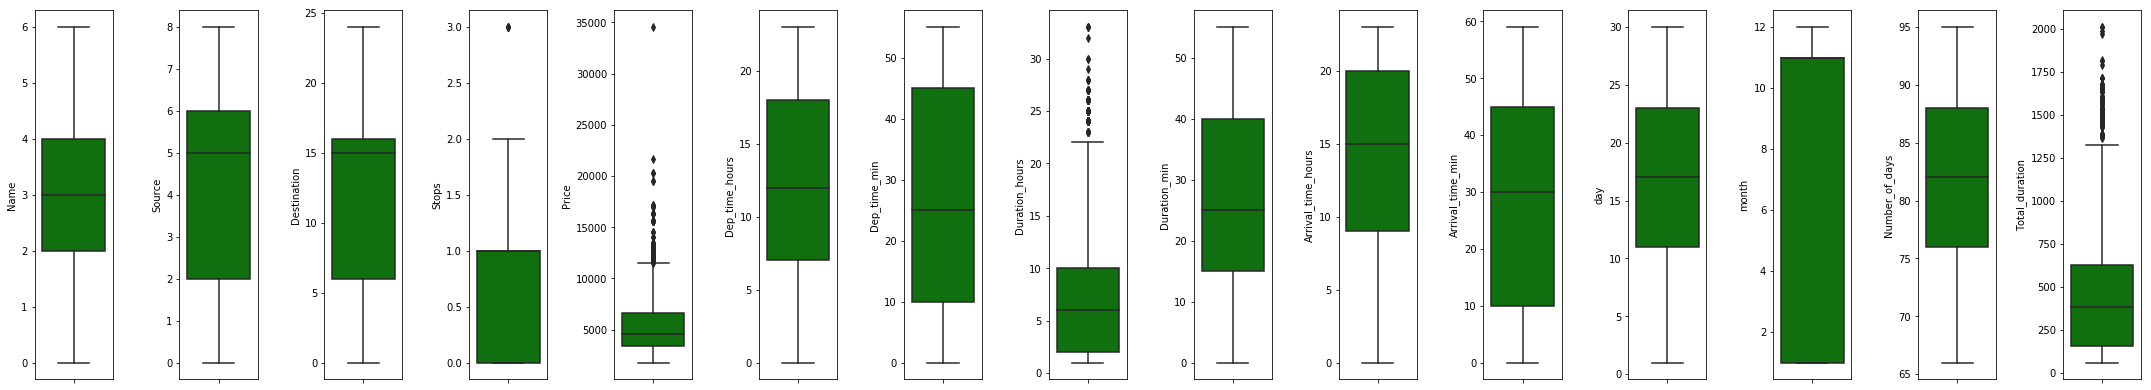

In [48]:
collist=data.columns.values
plt.figure(figsize=(40,80))
for i in range(0,len(collist)):
    plt.subplot(15,20,i+1)
    sns.boxplot(data[collist[i]],color='green',orient='v')
    plt.tight_layout()

We observe outliers in 'Price', 'Duration_hours' and 'Total_duration'

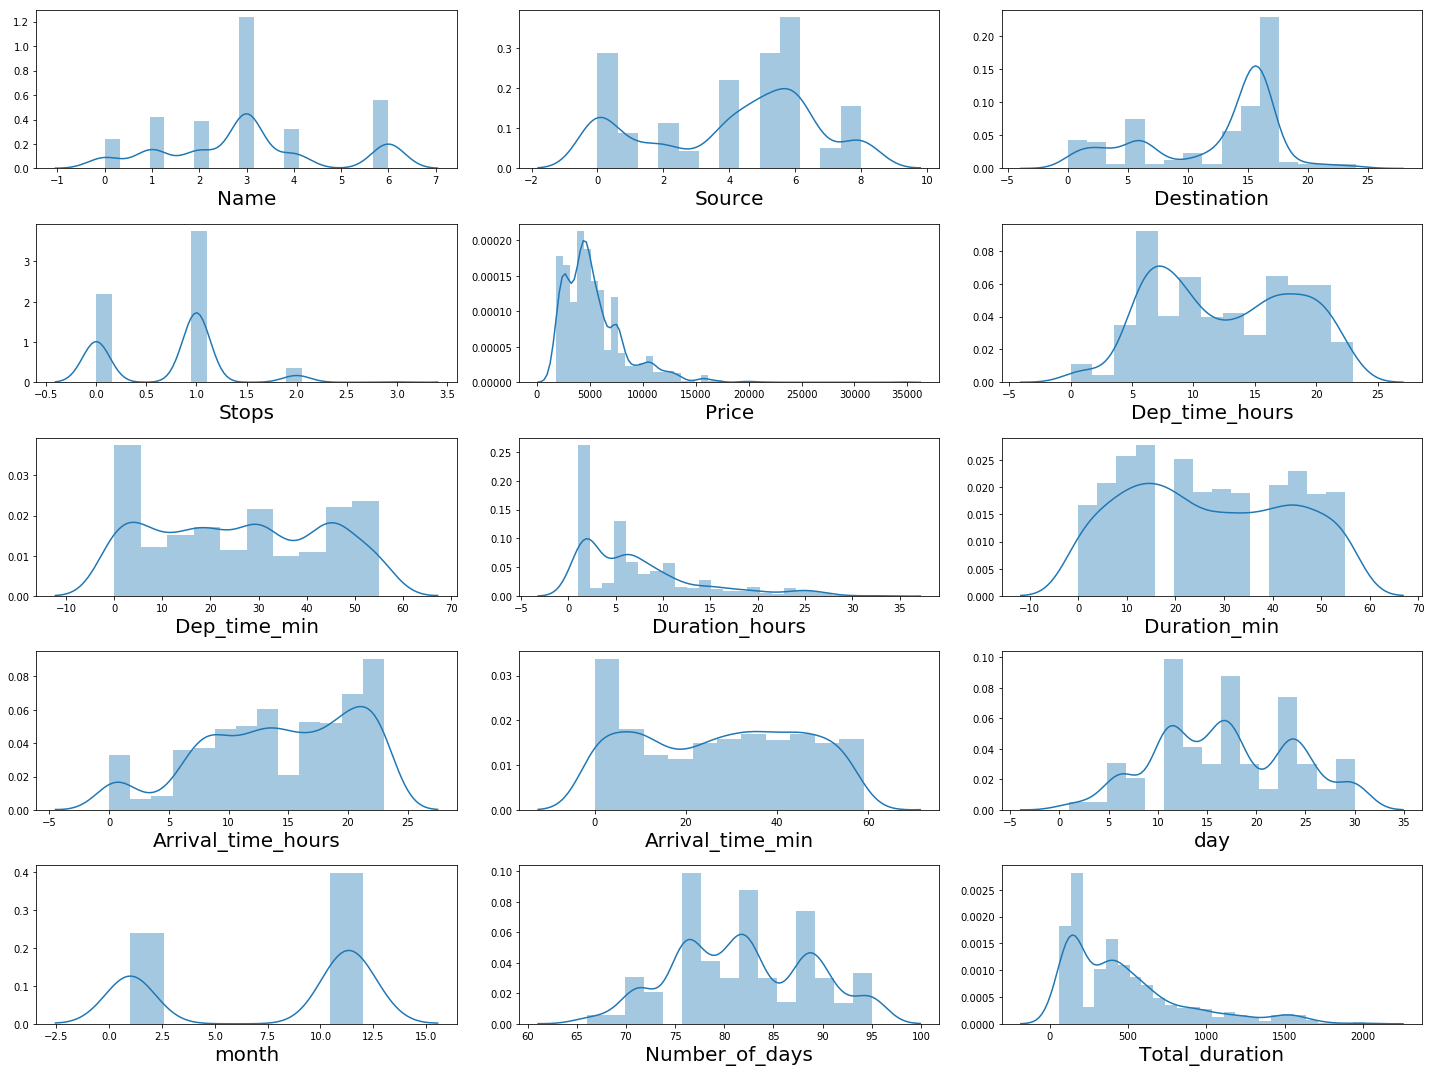

In [49]:
## checking for Normal Distribution of curve
plt.figure(figsize=(20,15),facecolor='white')
plotnumber=1

for column in data:
    if plotnumber<=15:
        ax=plt.subplot(5,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column, fontsize=20)
    plotnumber+=1
plt.tight_layout()

### Data Pre-Processing

We observed correlation between duration time as they tell the same thing, also we had observed outliers in these columns hence we will drop them.

In [50]:
data.drop(columns=["Duration_hours","Duration_min"],inplace=True)

In [51]:
data.skew()

Name                  0.282664
Source               -0.359224
Destination          -0.735556
Stops                 0.208783
Price                 1.891843
Dep_time_hours        0.049128
Dep_time_min          0.049050
Arrival_time_hours   -0.449847
Arrival_time_min     -0.039518
day                   0.070555
month                -0.499099
Number_of_days        0.070555
Total_duration        1.357099
dtype: float64

In [52]:
from scipy import stats
z=np.abs(stats.zscore(data))
index=(np.where(z>3)[0])
df_new=data.drop(data.index[index])
df_new.shape

(1828, 13)

In [53]:
print("Percentage of data loss = ",((1875-1828)/1875)*100)

Percentage of data loss =  2.506666666666667


In [54]:
df_new.skew()

Name                  0.280668
Source               -0.395066
Destination          -0.727022
Stops                 0.010327
Price                 1.088078
Dep_time_hours        0.039587
Dep_time_min          0.062718
Arrival_time_hours   -0.441030
Arrival_time_min     -0.030802
day                   0.038246
month                -0.469043
Number_of_days        0.038246
Total_duration        1.309348
dtype: float64

In [55]:
df_new["Total_duration"]=np.log(df_new["Total_duration"])
print(df_new.skew().loc["Total_duration"])

-0.054303560899945556


In [56]:
# Seperating feature and target variable
x=df_new.drop(columns=["Price"])
y=df_new["Price"]

In [57]:
## Scaling data
scale= StandardScaler()
x_scaled=scale.fit_transform(x)

## Model Building

In [58]:
#Finding the best random state and r2_score
for i in range(100):
    x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=.20,random_state=i)
    lr=LinearRegression()
    lr.fit(x_train,y_train)
    pred_train=lr.predict(x_train)
    pred_test=lr.predict(x_test)
    if round(r2_score(y_train,pred_train)*100,1)==round(r2_score(y_test,pred_test)*100,1):
        print('At random state',i,',the model performs well')
        print('Training r2_score is: ',r2_score(y_train,pred_train)*100)
        print('Testing r2_score is: ',r2_score(y_test,pred_test)*100)

At random state 52 ,the model performs well
Training r2_score is:  58.532365266999285
Testing r2_score is:  58.495003867753695
At random state 54 ,the model performs well
Training r2_score is:  58.5370270597652
Testing r2_score is:  58.476926499476775
At random state 81 ,the model performs well
Training r2_score is:  58.501148001440754
Testing r2_score is:  58.52425650963049


In [59]:
x_train,x_test,y_train,y_test=train_test_split(x_scaled,y,test_size=.20,random_state=81)

In [60]:
#Initializing the instance of the model
lm= LinearRegression()
knn= KNeighborsRegressor()
dt= DecisionTreeRegressor()
rmf= RandomForestRegressor()
gb= GradientBoostingRegressor()

models=[]
models.append(('LinearRegression',lr))
models.append(('KNeighborsRegressor',knn))
models.append(('DecisionTreeRegressor',dt))
models.append(('RandomForestRegressor',rmf))
models.append(('GradientBoostingRegressor',gb))

In [61]:
Model=[]
r2score=[]
mse=[]
cvs=[]
for name,model in models:
    print("****",name,"****")
    Model.append(name)
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    print('\n')
    AS=model.score(x_test,y_test)
    print('accuracy_score: ',AS)
    r2score.append(AS*100)
    print('\n')
    sc=cross_val_score(model,x_train,y_train,cv=5).mean()
    print('cross_val_score: ',sc)
    cvs.append(sc*100)
    print('\n')
    mse.append(mean_squared_error(y_test,y_pred))
    print('mean_squared_error ',mean_squared_error(y_test,y_pred))
    print('\n\n')

**** LinearRegression ****


accuracy_score:  0.5852425650963049


cross_val_score:  0.5727340366915723


mean_squared_error  2423438.683034735



**** KNeighborsRegressor ****


accuracy_score:  0.7460475895421008


cross_val_score:  0.7698852848280546


mean_squared_error  1483850.6639344261



**** DecisionTreeRegressor ****


accuracy_score:  0.7599649123898086


cross_val_score:  0.8201500680455596


mean_squared_error  1402531.3777322404



**** RandomForestRegressor ****


accuracy_score:  0.8606367626369499


cross_val_score:  0.8886455523278205


mean_squared_error  814303.0889777505



**** GradientBoostingRegressor ****


accuracy_score:  0.8261236774436168


cross_val_score:  0.8435510487665692


mean_squared_error  1015963.9603442102





In [62]:
df=pd.DataFrame({'Model':Model, 'Accuracy_score': r2score,'Cross_val_score':cvs,'Mean_Squared_Error':mse})
df

,Model,Accuracy_score,Cross_val_score,Mean_Squared_Error
0,LinearRegression,58.524257,57.273404,2.423439e+06
1,KNeighborsRegressor,74.604759,76.988528,1.483851e+06
2,DecisionTreeRegressor,75.996491,82.015007,1.402531e+06
3,RandomForestRegressor,86.063676,88.864555,8.143031e+05
4,GradientBoostingRegressor,82.612368,84.355105,1.015964e+06


By looking at various metrics, Random Forest Regressor is considered to be the best model. We will now use GridSearchCV to tune model for better results.

### Hyper-Parametric Tuning

In [63]:
rmf= RandomForestRegressor()
params={'max_features':['auto','sqrt'],'n_estimators':[50,80], 'criterion':['mse','mae'],
       'max_depth':[5,10], 'min_samples_split':[4,6],
       'min_samples_leaf':[2,3]}
grd=GridSearchCV(rmf,param_grid=params)
grd.fit(x_train,y_train)
print('best params=>',grd.best_params_)

best params=> {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50}


In [64]:
rmf= RandomForestRegressor(criterion= 'mse', max_depth= 10, max_features= 'auto', min_samples_leaf= 2, 
                           min_samples_split= 4, n_estimators= 50)
rmf.fit(x_train,y_train)
y_pred=rmf.predict(x_test)
print("Random Forest Regression: Accuracy = ",rmf.score(x_test,y_test))
print("\n Mean Squared Error= ",mean_squared_error(y_test,y_pred))
print("\n Root Mean Squared Error= ",np.sqrt(mean_squared_error(y_test,y_pred)))
print("\n Mean Absolute Error= ",mean_absolute_error(y_test,y_pred))

Random Forest Regression: Accuracy =  0.8453601476367489

 Mean Squared Error=  903564.7552476081

 Root Mean Squared Error=  950.5602323091409

 Mean Absolute Error=  547.8271263504754


In [65]:
#Comparing actual and predicted values with the help of a dataframe
predictions=pd.DataFrame({'Original_price':y_test, 'Predicted_price':y_pred})
predictions

,Original_price,Predicted_price
196,2126,2204.848000
1250,7487,7527.094500
1117,3513,2955.645642
1201,5941,5456.679404
1452,7489,7476.393333
...,...,...
205,4002,5024.182102
1163,4754,5470.688316
455,6367,6126.394908
1611,4429,7027.430524


In [66]:
## savig model
filename= "flightPrice_prediction.pickle"
pickle.dump(rmf, open(filename, 'wb'))

------